In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [9]:
def calculate_risk_contribution(tickers, weights, start_date, end_date):
    """
    Calculates and plots the risk contribution of assets in a portfolio.

    Args:
        tickers (list): List of ticker symbols (e.g., ['SPY', 'BND']).
        weights (list): List of portfolio weights corresponding to tickers.
        start_date (str): Start date for historical data ('YYYY-MM-DD').
        end_date (str): End date for historical data ('YYYY-MM-DD').

    Returns:
        pandas.Series: Percentage risk contributions of each asset.
    """
    # --- 1. Download Data ---
    adj_close = yf.download(tickers, start=start_date, end=end_date)['Close']

    # --- 2. Calculate Daily Returns ---
    returns = adj_close.pct_change().dropna()

    # --- 3. Calculate Annualized Covariance Matrix ---
    # Use 252 trading days for annualization
    cov_matrix_annual = returns.cov() * 252

    # --- 4. Calculate Portfolio Volatility ---
    w = np.array(weights) # Ensure weights is a numpy array
    portfolio_variance = w.T @ cov_matrix_annual @ w
    portfolio_volatility = np.sqrt(portfolio_variance)

    # --- 5. Calculate Marginal Contribution to Risk (MCR) ---
    # MCR_i = (CovarianceMatrix * Weights)_i / PortfolioVolatility
    sigma_times_w = cov_matrix_annual.dot(w)
    mcr = sigma_times_w / portfolio_volatility

    # --- 6. Calculate Risk Contribution (RC) ---
    # RC_i = Weight_i * MCR_i
    rc = w * mcr

    # --- 7. Calculate Percentage Risk Contribution ---
    # %RC_i = RC_i / PortfolioVolatility
    percent_rc = rc / portfolio_volatility

    # Ensure results sum to 1 (or close due to float precision)
    # print(f"Sum of % Risk Contributions: {percent_rc.sum():.4f}") # Debug check

    # --- 8. Prepare Output ---
    percent_rc_series = pd.Series(percent_rc, index=tickers)

    print("-" * 40)
    print(f"Portfolio Annualized Volatility: {portfolio_volatility:.2%}")
    print("-" * 40)
    print("Asset Contributions to Portfolio Risk:")
    print(percent_rc_series.apply(lambda x: f"{x:.2%}"))
    print("-" * 40)


    # --- 9. Plotting ---
    fig, ax = plt.subplots(figsize=(8, 6))
    percent_rc_series.plot(kind='bar', ax=ax)

    ax.set_title(f'Riziková alokace pro {int(w[0]*100)}/{int(w[1]*100)} Portfolio ({start_date} to {end_date})')
    ax.set_ylabel('% kontribuce k volatilitě portfolia')
    ax.set_xlabel('Instrumenty')
    ax.set_xticklabels(percent_rc_series.index, rotation=0)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) # Format y-axis as percentage

    # Add percentage labels on top of bars
    for i, v in enumerate(percent_rc_series):
        ax.text(i, v + 0.01, f"{v:.1%}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return percent_rc_series

[*********************100%***********************]  2 of 2 completed


----------------------------------------
Portfolio Annualized Volatility: 8.54%
----------------------------------------
Asset Contributions to Portfolio Risk:
IWB    86.94%
BND    13.06%
dtype: object
----------------------------------------


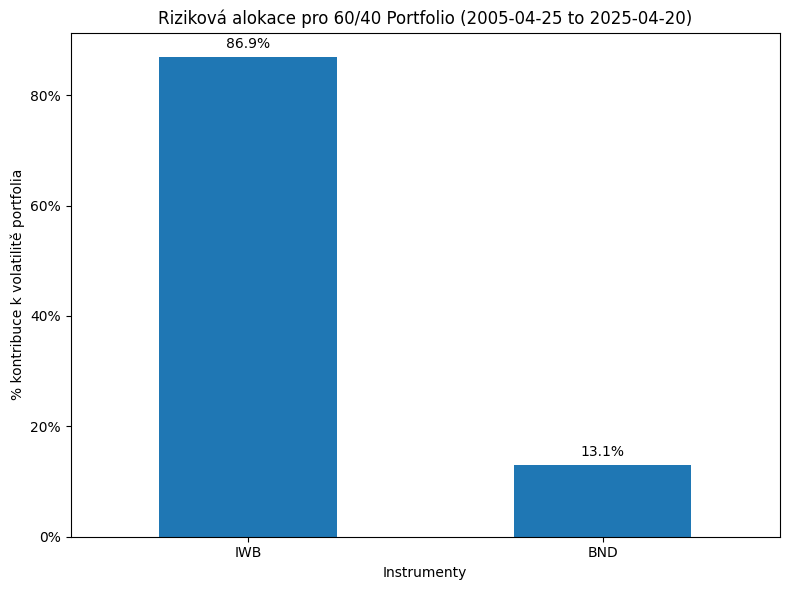

In [11]:
# --- Configuration ---
tickers = ['IWB', 'BND']
weights = [0.60, 0.40] # 60% SPY, 40% BND

# Define date range (e.g., last 10 years)
end_dt = datetime.now()
start_dt = end_dt - timedelta(days=20*365)

start_date_str = start_dt.strftime('%Y-%m-%d')
end_date_str = end_dt.strftime('%Y-%m-%d')

# --- Run Calculation and Plot ---
risk_contributions = calculate_risk_contribution(tickers, weights, start_date_str, end_date_str)